In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from forecasting import ForecastingEngine
from visualization import AadhaarVisualizer

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load and Prepare Data

In [2]:
print("Loading processed datasets...")

enrolment_df = pd.read_parquet('../outputs/enrolment_processed.parquet')
demographic_df = pd.read_parquet('../outputs/demographic_processed.parquet')
biometric_df = pd.read_parquet('../outputs/biometric_processed.parquet')

print(f"✓ Enrolment: {len(enrolment_df):,} records")
print(f"✓ Demographic: {len(demographic_df):,} records")
print(f"✓ Biometric: {len(biometric_df):,} records")

# Initialize forecasting engine
forecaster = ForecastingEngine()
visualizer = AadhaarVisualizer(output_dir='../outputs/figures')

print("✓ Forecasting engine initialized")

Loading processed datasets...
✓ Enrolment: 200,255 records
✓ Demographic: 395,409 records
✓ Biometric: 368,316 records
✓ Forecasting engine initialized


## 2. Prepare Time Series for Forecasting

Time series shape: (88,)
Date range: 2025-03-09 00:00:00 to 2025-12-31 00:00:00
Total days: 88
Mean daily enrolments: 12,456
Std deviation: 15,885

Train set: 70 days
Test set: 18 days
Train period: 2025-03-09 00:00:00 to 2025-11-13 00:00:00
Test period: 2025-11-14 00:00:00 to 2025-12-31 00:00:00


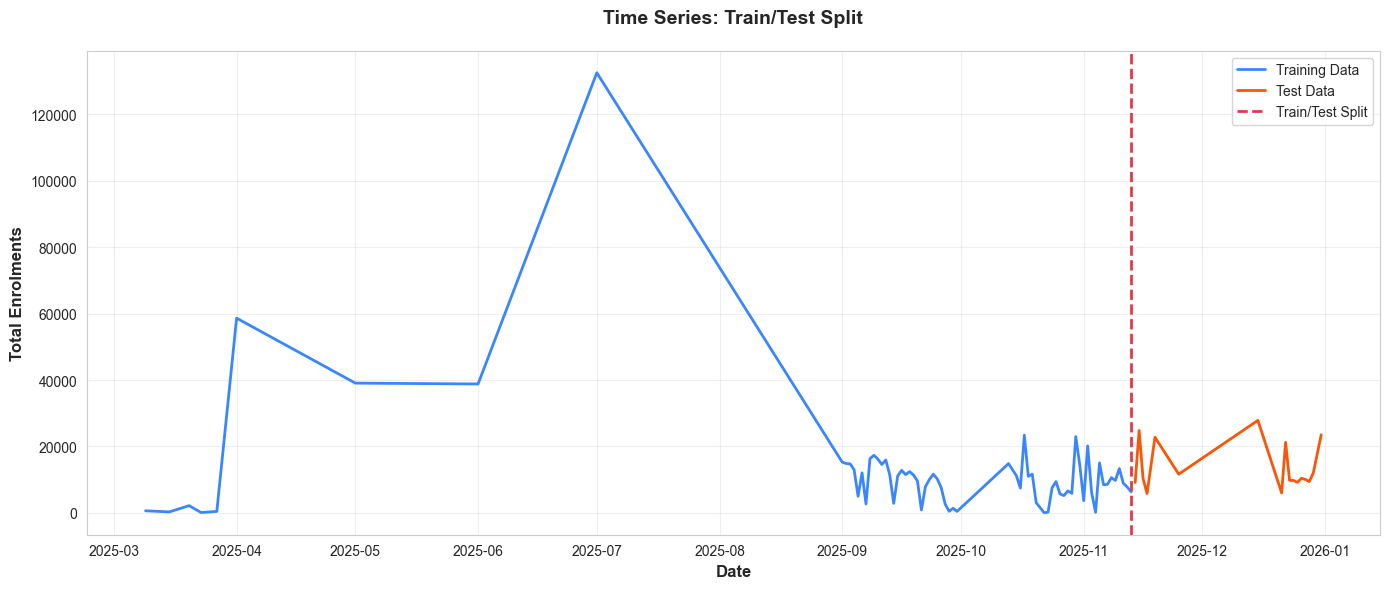

In [3]:
# Create daily time series
daily_ts = enrolment_df.groupby('date')['total_enrolments'].sum().sort_index()

print(f"Time series shape: {daily_ts.shape}")
print(f"Date range: {daily_ts.index.min()} to {daily_ts.index.max()}")
print(f"Total days: {len(daily_ts)}")
print(f"Mean daily enrolments: {daily_ts.mean():,.0f}")
print(f"Std deviation: {daily_ts.std():,.0f}")

# Split into train/test (80/20)
train_size = int(len(daily_ts) * 0.8)
train_data = daily_ts[:train_size]
test_data = daily_ts[train_size:]

print(f"\nTrain set: {len(train_data)} days")
print(f"Test set: {len(test_data)} days")
print(f"Train period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, train_data.values, 
        color='#3A86FF', linewidth=2, label='Training Data')
ax.plot(test_data.index, test_data.values, 
        color='#FB5607', linewidth=2, label='Test Data')
ax.axvline(x=train_data.index[-1], color='#E63946', 
          linestyle='--', linewidth=2, label='Train/Test Split')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Time Series: Train/Test Split', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/29_train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. BASELINE MODELS

### 3.1 Naive Forecast

=== NAIVE FORECAST ===

Method: Last observed value = 6,349
Forecast length: 18 days

Error Metrics:
  MAE:  7,533
  RMSE: 10,022
  MAPE: 44.94%


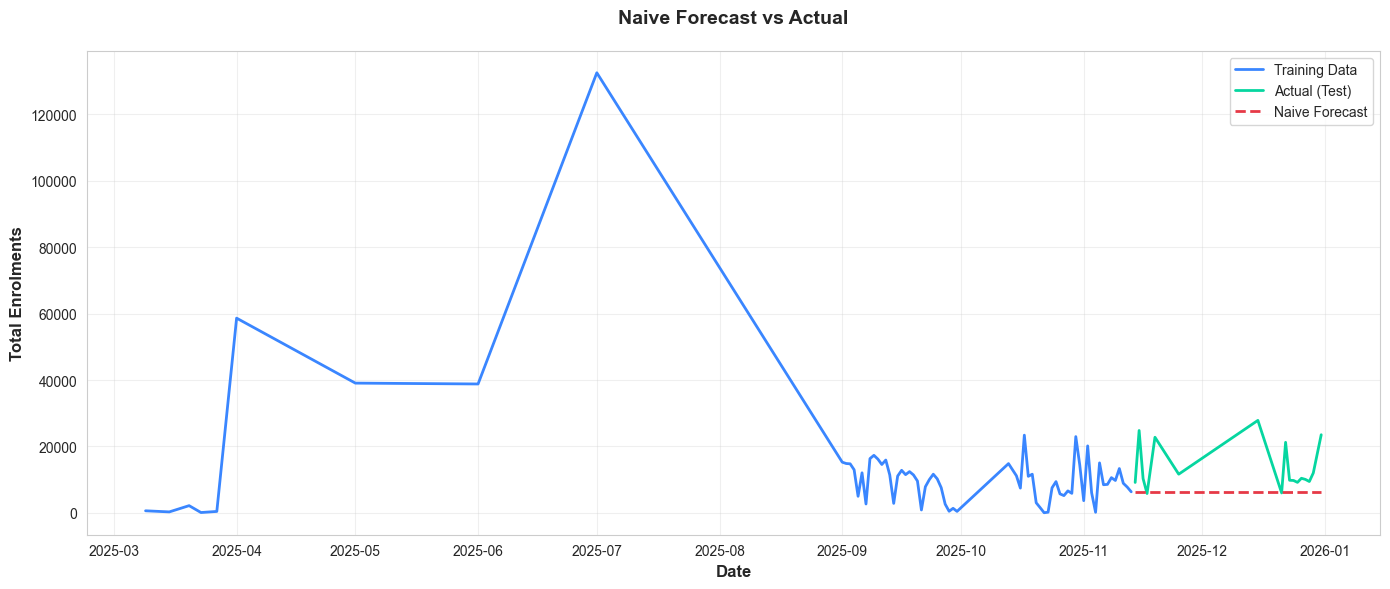

In [4]:
# Naive forecast (last observation carried forward)
naive_result = forecaster.naive_forecast(train_data, periods=len(test_data))
naive_forecast = naive_result['forecast'].values

print(f"=== NAIVE FORECAST ===\n")
print(f"Method: Last observed value = {train_data.iloc[-1]:,.0f}")
print(f"Forecast length: {len(naive_forecast)} days")

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_naive = mean_absolute_error(test_data.values, naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test_data.values, naive_forecast))
mape_naive = np.mean(np.abs((test_data.values - naive_forecast) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_naive:,.0f}")
print(f"  RMSE: {rmse_naive:,.0f}")
print(f"  MAPE: {mape_naive:.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, train_data.values, 
        color='#3A86FF', linewidth=2, label='Training Data')
ax.plot(test_data.index, test_data.values, 
        color='#06D6A0', linewidth=2, label='Actual (Test)')
ax.plot(test_data.index, naive_forecast, 
        color='#E63946', linewidth=2, linestyle='--', label='Naive Forecast')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Naive Forecast vs Actual', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/30_naive_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Moving Average Forecast

=== MOVING AVERAGE FORECAST ===

Window size: 7 days
Forecast length: 18 days

Error Metrics:
  MAE:  5,248
  RMSE: 8,061
  MAPE: 29.89%


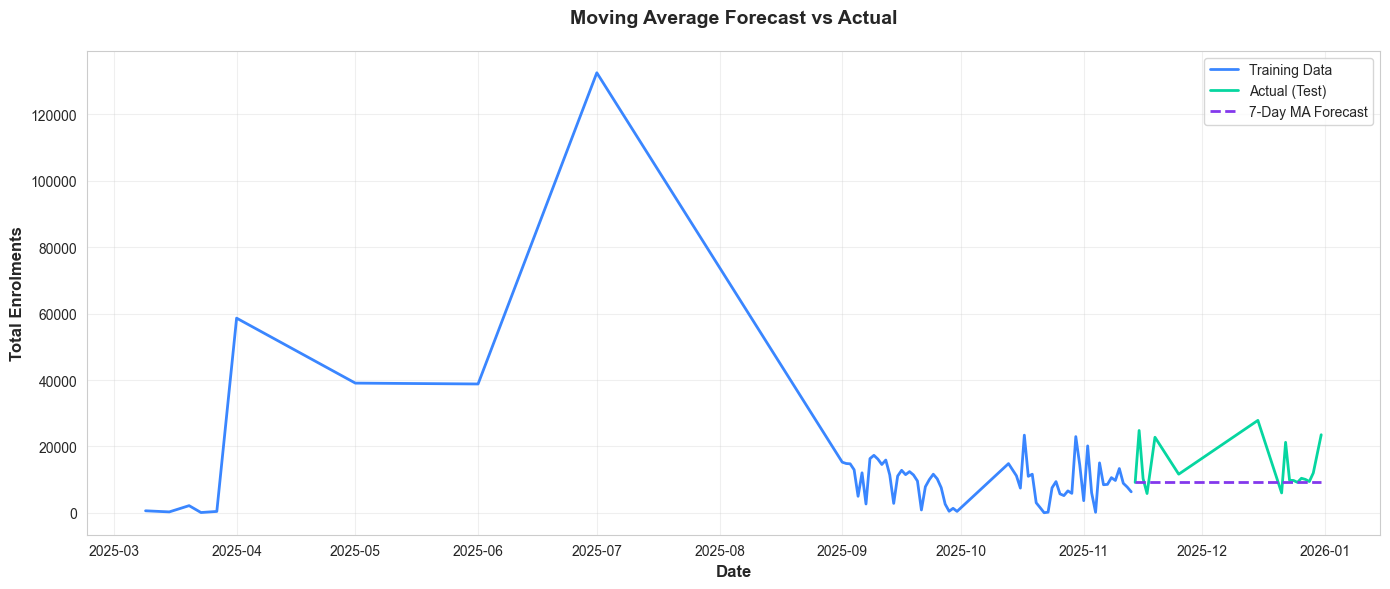

In [5]:
# Moving average forecast
ma_window = 7  # 7-day moving average
ma_result = forecaster.simple_moving_average_forecast(
    train_data, 
    window=ma_window, 
    periods=len(test_data)
)
ma_forecast = ma_result['forecast'].values

print(f"=== MOVING AVERAGE FORECAST ===\n")
print(f"Window size: {ma_window} days")
print(f"Forecast length: {len(ma_forecast)} days")

mae_ma = mean_absolute_error(test_data.values, ma_forecast)
rmse_ma = np.sqrt(mean_squared_error(test_data.values, ma_forecast))
mape_ma = np.mean(np.abs((test_data.values - ma_forecast) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_ma:,.0f}")
print(f"  RMSE: {rmse_ma:,.0f}")
print(f"  MAPE: {mape_ma:.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, train_data.values, 
        color='#3A86FF', linewidth=2, label='Training Data')
ax.plot(test_data.index, test_data.values, 
        color='#06D6A0', linewidth=2, label='Actual (Test)')
ax.plot(test_data.index, ma_forecast, 
        color='#8338EC', linewidth=2, linestyle='--', label=f'{ma_window}-Day MA Forecast')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Moving Average Forecast vs Actual', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/31_moving_average_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Seasonal Naive Forecast

In [6]:
# Seasonal naive (weekly seasonality)
seasonal_period = 7
seasonal_naive_result = forecaster.seasonal_naive_forecast(
    train_data, 
    seasonal_period=seasonal_period, 
    periods=len(test_data)
)
seasonal_naive_forecast = seasonal_naive_result['forecast'].values

print(f"=== SEASONAL NAIVE FORECAST ===\n")
print(f"Seasonal period: {seasonal_period} days (weekly)")
print(f"Forecast length: {len(seasonal_naive_forecast)} days")

mae_sn = mean_absolute_error(test_data.values, seasonal_naive_forecast)
rmse_sn = np.sqrt(mean_squared_error(test_data.values, seasonal_naive_forecast))
mape_sn = np.mean(np.abs((test_data.values - seasonal_naive_forecast) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_sn:,.0f}")
print(f"  RMSE: {rmse_sn:,.0f}")
print(f"  MAPE: {mape_sn:.2f}%")

=== SEASONAL NAIVE FORECAST ===

Seasonal period: 7 days (weekly)
Forecast length: 18 days

Error Metrics:
  MAE:  6,048
  RMSE: 8,196
  MAPE: 40.85%


## 4. EXPONENTIAL SMOOTHING

### 4.1 Simple Exponential Smoothing

In [7]:
# Simple exponential smoothing
ses_result = forecaster.exponential_smoothing_forecast(
    train_data,
    periods=len(test_data),
    seasonal_periods=None,  # No seasonality
    trend=None,  # No trend
    seasonal=None
)

print(f"=== SIMPLE EXPONENTIAL SMOOTHING ===\n")
print(f"Forecast length: {len(ses_result['forecast'])} days")

mae_ses = mean_absolute_error(test_data.values, ses_result['forecast'].values)
rmse_ses = np.sqrt(mean_squared_error(test_data.values, ses_result['forecast'].values))
mape_ses = np.mean(np.abs((test_data.values - ses_result['forecast'].values) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_ses:,.0f}")
print(f"  RMSE: {rmse_ses:,.0f}")
print(f"  MAPE: {mape_ses:.2f}%")

=== SIMPLE EXPONENTIAL SMOOTHING ===

Forecast length: 18 days

Error Metrics:
  MAE:  6,277
  RMSE: 8,890
  MAPE: 36.58%


### 4.2 Holt's Linear Trend (Double Exponential Smoothing)

In [8]:
# Double exponential smoothing (with trend)
des_result = forecaster.exponential_smoothing_forecast(
    train_data,
    periods=len(test_data),
    seasonal_periods=None,
    trend='add',  # Additive trend
    seasonal=None
)

print(f"=== HOLT'S LINEAR TREND (DOUBLE EXPONENTIAL SMOOTHING) ===\n")
print(f"Trend type: Additive")
print(f"Forecast length: {len(des_result['forecast'])} days")

mae_des = mean_absolute_error(test_data.values, des_result['forecast'].values)
rmse_des = np.sqrt(mean_squared_error(test_data.values, des_result['forecast'].values))
mape_des = np.mean(np.abs((test_data.values - des_result['forecast'].values) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_des:,.0f}")
print(f"  RMSE: {rmse_des:,.0f}")
print(f"  MAPE: {mape_des:.2f}%")

=== HOLT'S LINEAR TREND (DOUBLE EXPONENTIAL SMOOTHING) ===

Trend type: Additive
Forecast length: 18 days

Error Metrics:
  MAE:  8,010
  RMSE: 10,357
  MAPE: 49.33%


### 4.3 Holt-Winters (Triple Exponential Smoothing)

=== HOLT-WINTERS (TRIPLE EXPONENTIAL SMOOTHING) ===

Trend type: Additive
Seasonal period: 7 days (weekly)
Forecast length: 18 days

Error Metrics:
  MAE:  8,321
  RMSE: 10,661
  MAPE: 68.74%


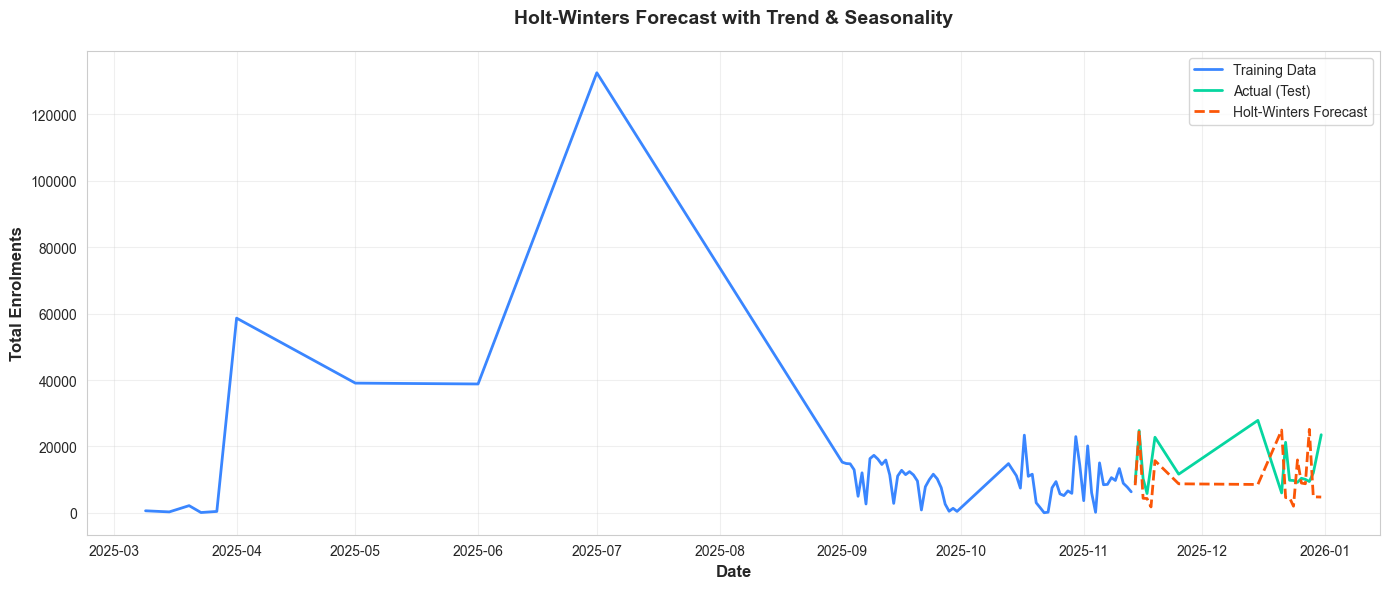

In [9]:
# Triple exponential smoothing (with trend and seasonality)
tes_result = forecaster.exponential_smoothing_forecast(
    train_data,
    periods=len(test_data),
    seasonal_periods=7,  # Weekly seasonality
    trend='add',
    seasonal='add'
)

print(f"=== HOLT-WINTERS (TRIPLE EXPONENTIAL SMOOTHING) ===\n")
print(f"Trend type: Additive")
print(f"Seasonal period: 7 days (weekly)")
print(f"Forecast length: {len(tes_result['forecast'])} days")

mae_tes = mean_absolute_error(test_data.values, tes_result['forecast'].values)
rmse_tes = np.sqrt(mean_squared_error(test_data.values, tes_result['forecast'].values))
mape_tes = np.mean(np.abs((test_data.values - tes_result['forecast'].values) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_tes:,.0f}")
print(f"  RMSE: {rmse_tes:,.0f}")
print(f"  MAPE: {mape_tes:.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, train_data.values, 
        color='#3A86FF', linewidth=2, label='Training Data')
ax.plot(test_data.index, test_data.values, 
        color='#06D6A0', linewidth=2, label='Actual (Test)')
ax.plot(test_data.index, tes_result['forecast'].values, 
        color='#FB5607', linewidth=2, linestyle='--', label='Holt-Winters Forecast')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Holt-Winters Forecast with Trend & Seasonality', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/32_holt_winters_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. ARIMA MODELING

### 5.1 Auto ARIMA (Optimal Parameters)

=== ARIMA MODELING ===
Fitting ARIMA model (this may take a minute)...

ARIMA Order: (1, 1, 1)
Forecast length: 18 days
AIC: 1547.48
BIC: 1554.18

Error Metrics:
  MAE:  5,143
  RMSE: 7,949
  MAPE: 29.48%


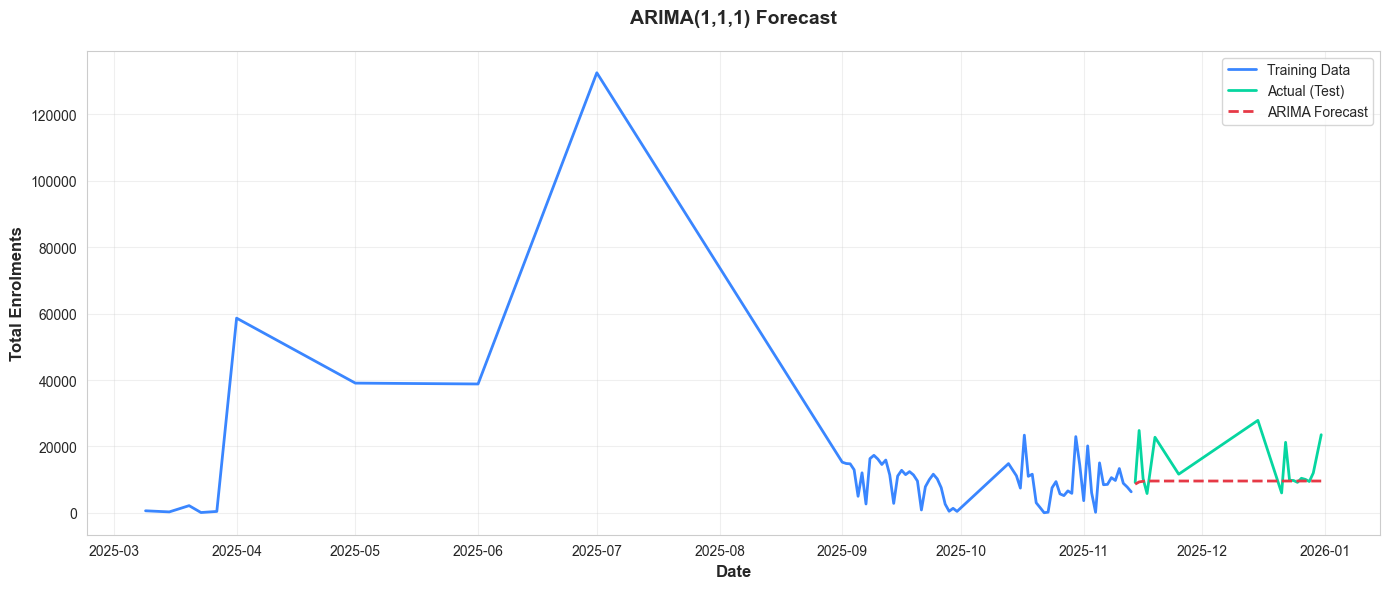

In [10]:
# Fit ARIMA model
print("=== ARIMA MODELING ===")
print("Fitting ARIMA model (this may take a minute)...")

arima_result = forecaster.arima_forecast(
    train_data,
    periods=len(test_data),
    order=(1, 1, 1)  # (p, d, q) - can be optimized
)

print(f"\nARIMA Order: (1, 1, 1)")
print(f"Forecast length: {len(arima_result['forecast'])} days")
print(f"AIC: {arima_result['aic']:.2f}")
print(f"BIC: {arima_result['bic']:.2f}")

mae_arima = mean_absolute_error(test_data.values, arima_result['forecast'].values)
rmse_arima = np.sqrt(mean_squared_error(test_data.values, arima_result['forecast'].values))
mape_arima = np.mean(np.abs((test_data.values - arima_result['forecast'].values) / test_data.values)) * 100

print(f"\nError Metrics:")
print(f"  MAE:  {mae_arima:,.0f}")
print(f"  RMSE: {rmse_arima:,.0f}")
print(f"  MAPE: {mape_arima:.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train_data.index, train_data.values, 
        color='#3A86FF', linewidth=2, label='Training Data')
ax.plot(test_data.index, test_data.values, 
        color='#06D6A0', linewidth=2, label='Actual (Test)')
ax.plot(test_data.index, arima_result['forecast'].values, 
        color='#E63946', linewidth=2, linestyle='--', label='ARIMA Forecast')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('ARIMA(1,1,1) Forecast', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/33_arima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. MODEL COMPARISON

### 6.1 Performance Metrics Summary

MODEL COMPARISON - PERFORMANCE METRICS

                    Model         MAE         RMSE      MAPE
                   ARIMA 5143.083667  7949.169449 29.481539
          Moving Average 5248.317460  8061.101567 29.887389
          Seasonal Naive 6047.500000  8195.791457 40.851034
               Simple ES 6277.115973  8890.000051 36.582508
                   Naive 7533.444444 10022.496429 44.937548
        Double ES (Holt) 8009.883476 10357.099815 49.333422
Triple ES (Holt-Winters) 8320.873143 10660.725455 68.741739

🏆 BEST MODEL: ARIMA
   MAE: 5,143
   RMSE: 7,949
   MAPE: 29.48%


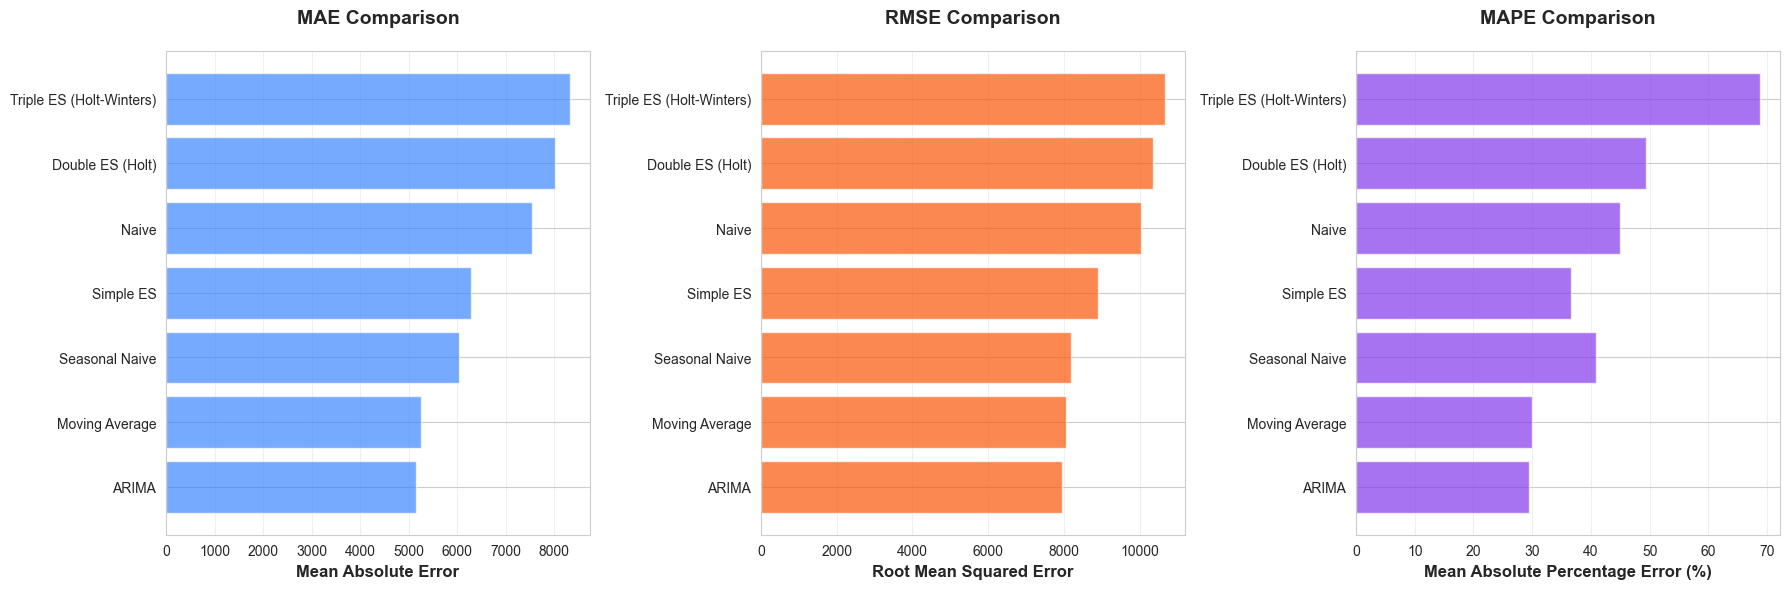

In [11]:
# Compile all model results
model_comparison = pd.DataFrame({
    'Model': ['Naive', 'Moving Average', 'Seasonal Naive', 
             'Simple ES', 'Double ES (Holt)', 'Triple ES (Holt-Winters)', 'ARIMA'],
    'MAE': [mae_naive, mae_ma, mae_sn, mae_ses, mae_des, mae_tes, mae_arima],
    'RMSE': [rmse_naive, rmse_ma, rmse_sn, rmse_ses, rmse_des, rmse_tes, rmse_arima],
    'MAPE': [mape_naive, mape_ma, mape_sn, mape_ses, mape_des, mape_tes, mape_arima]
})

# Sort by MAE
model_comparison = model_comparison.sort_values('MAE')

print("="*80)
print("MODEL COMPARISON - PERFORMANCE METRICS")
print("="*80)
print("\n", model_comparison.to_string(index=False))

# Best model
best_model = model_comparison.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   MAE: {best_model['MAE']:,.0f}")
print(f"   RMSE: {best_model['RMSE']:,.0f}")
print(f"   MAPE: {best_model['MAPE']:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE
axes[0].barh(model_comparison['Model'], model_comparison['MAE'], color='#3A86FF', alpha=0.7)
axes[0].set_xlabel('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].set_title('MAE Comparison', fontweight='bold', fontsize=14, pad=20)
axes[0].grid(True, axis='x', alpha=0.3)

# RMSE
axes[1].barh(model_comparison['Model'], model_comparison['RMSE'], color='#FB5607', alpha=0.7)
axes[1].set_xlabel('Root Mean Squared Error', fontweight='bold', fontsize=12)
axes[1].set_title('RMSE Comparison', fontweight='bold', fontsize=14, pad=20)
axes[1].grid(True, axis='x', alpha=0.3)

# MAPE
axes[2].barh(model_comparison['Model'], model_comparison['MAPE'], color='#8338EC', alpha=0.7)
axes[2].set_xlabel('Mean Absolute Percentage Error (%)', fontweight='bold', fontsize=12)
axes[2].set_title('MAPE Comparison', fontweight='bold', fontsize=14, pad=20)
axes[2].grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/34_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.2 Visual Comparison of Best Models

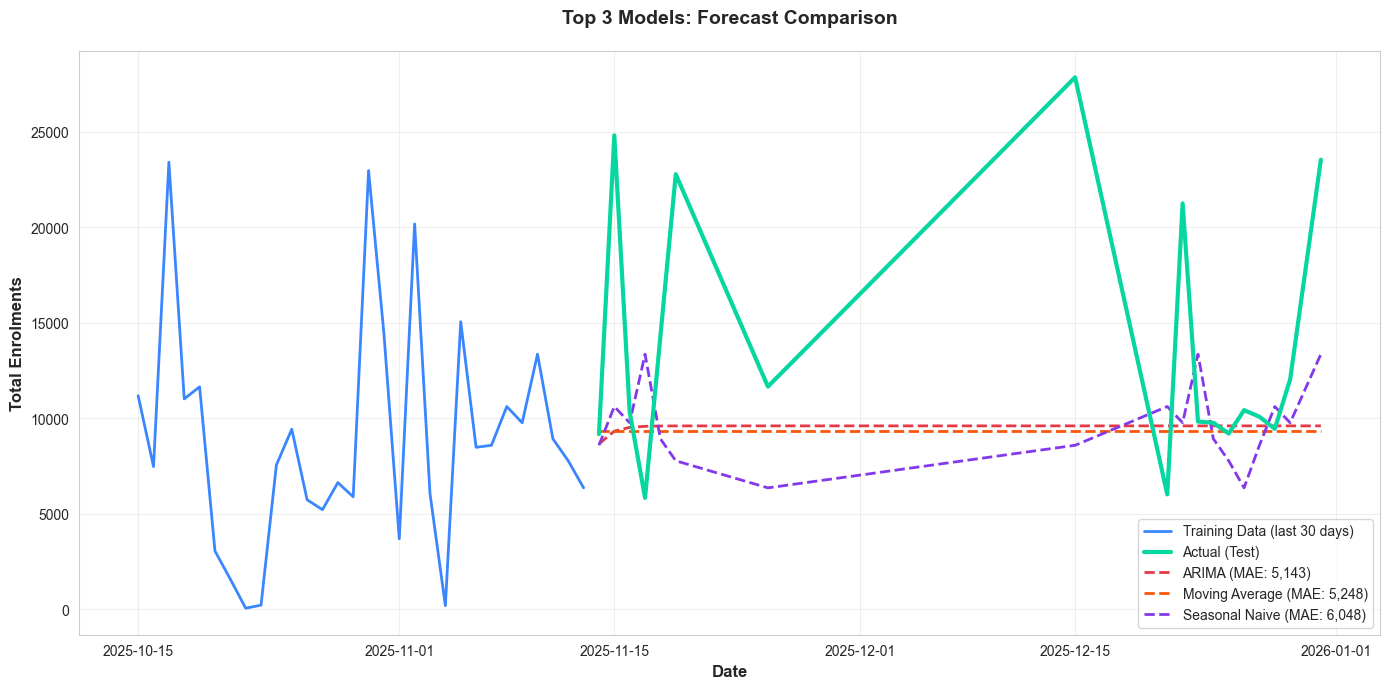

In [12]:
# Plot top 3 models together
top3_models = model_comparison.head(3)

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(train_data.index[-30:], train_data.values[-30:], 
        color='#3A86FF', linewidth=2, label='Training Data (last 30 days)')
ax.plot(test_data.index, test_data.values, 
        color='#06D6A0', linewidth=3, label='Actual (Test)', zorder=5)

# Plot forecasts from best models
colors = ['#E63946', '#FB5607', '#8338EC']
forecasts = [
    ('Naive', naive_forecast),
    ('Moving Average', ma_forecast),
    ('Seasonal Naive', seasonal_naive_forecast),
    ('Simple ES', ses_result['forecast']),
    ('Double ES', des_result['forecast']),
    ('Triple ES', tes_result['forecast']),
    ('ARIMA', arima_result['forecast'])
]

# Get forecasts for top 3 models
for i, model_name in enumerate(top3_models['Model']):
    forecast = [f[1] for f in forecasts if f[0] == model_name][0]
    ax.plot(test_data.index, forecast, 
           color=colors[i], linewidth=2, linestyle='--', 
           label=f'{model_name} (MAE: {top3_models.iloc[i]["MAE"]:,.0f})')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Top 3 Models: Forecast Comparison', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/35_top_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. FUTURE FORECAST (Next 30 Days)

### 7.1 Generate Production Forecast

=== FUTURE FORECAST ===
Using best model: ARIMA
Forecast horizon: 30 days

Forecast period: 2026-01-01 to 2026-01-30

Forecast statistics:
  Mean: 12,132
  Min:  11,977
  Max:  15,293
  Total expected: 363,959

Next 30 days forecast:
  2026-01-01: 15,293
  2026-01-02: 12,929
  2026-01-03: 12,250
  2026-01-04: 12,055
  2026-01-05: 11,999
  2026-01-06: 11,983
  2026-01-07: 11,979
  2026-01-08: 11,977
  2026-01-09: 11,977
  2026-01-10: 11,977
  2026-01-11: 11,977
  2026-01-12: 11,977
  2026-01-13: 11,977
  2026-01-14: 11,977
  2026-01-15: 11,977
  2026-01-16: 11,977
  2026-01-17: 11,977
  2026-01-18: 11,977
  2026-01-19: 11,977
  2026-01-20: 11,977
  2026-01-21: 11,977
  2026-01-22: 11,977
  2026-01-23: 11,977
  2026-01-24: 11,977
  2026-01-25: 11,977
  2026-01-26: 11,977
  2026-01-27: 11,977
  2026-01-28: 11,977
  2026-01-29: 11,977
  2026-01-30: 11,977


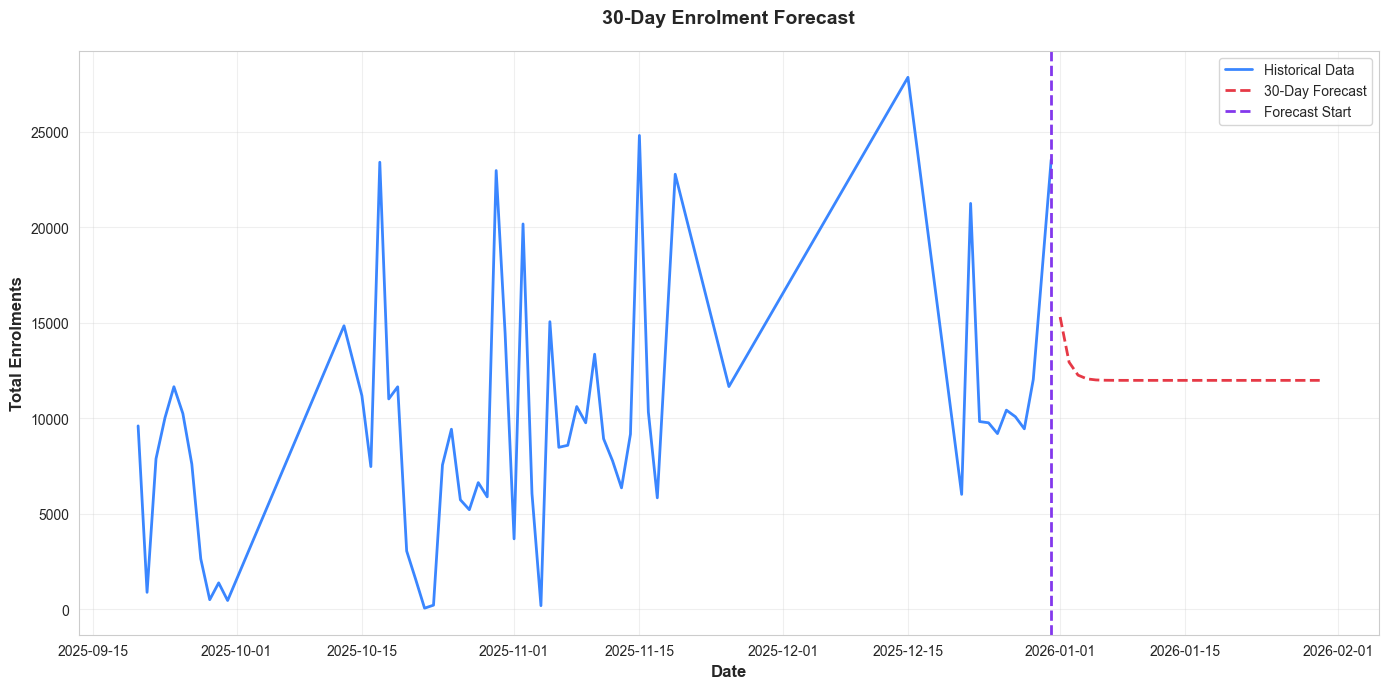

In [13]:
# Use best model to forecast next 30 days
forecast_horizon = 30
print(f"=== FUTURE FORECAST ===")
print(f"Using best model: {best_model['Model']}")
print(f"Forecast horizon: {forecast_horizon} days")

# Retrain on full dataset
full_ts = daily_ts

# Generate forecast based on best model
if best_model['Model'] == 'Triple ES (Holt-Winters)':
    future_result = forecaster.exponential_smoothing_forecast(
        full_ts,
        periods=forecast_horizon,
        seasonal_periods=7,
        trend='add',
        seasonal='add'
    )
elif best_model['Model'] == 'ARIMA':
    future_result = forecaster.arima_forecast(
        full_ts,
        periods=forecast_horizon,
        order=(1, 1, 1)
    )
else:
    # Fallback to Holt-Winters
    future_result = forecaster.exponential_smoothing_forecast(
        full_ts,
        periods=forecast_horizon,
        seasonal_periods=7,
        trend='add',
        seasonal='add'
    )

# Create future dates
last_date = daily_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                             periods=forecast_horizon, freq='D')

print(f"\nForecast period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
print(f"\nForecast statistics:")
print(f"  Mean: {future_result['forecast'].mean():,.0f}")
print(f"  Min:  {future_result['forecast'].min():,.0f}")
print(f"  Max:  {future_result['forecast'].max():,.0f}")
print(f"  Total expected: {future_result['forecast'].sum():,.0f}")

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecast': future_result['forecast'].values
})

print("\nNext 30 days forecast:")
for idx, row in forecast_df.iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['forecast']:,.0f}")

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data (last 60 days)
ax.plot(daily_ts.index[-60:], daily_ts.values[-60:], 
        color='#3A86FF', linewidth=2, label='Historical Data')

# Future forecast
ax.plot(future_dates, future_result['forecast'].values, 
        color='#E63946', linewidth=2, linestyle='--', label='30-Day Forecast')

# Mark forecast start
ax.axvline(x=last_date, color='#8338EC', 
          linestyle='--', linewidth=2, label='Forecast Start')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('30-Day Enrolment Forecast', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/36_future_forecast_30days.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. DEMAND PLANNING INSIGHTS

In [14]:
# Calculate resource planning metrics
daily_avg = future_result['forecast'].mean()
weekly_total = daily_avg * 7
monthly_total = daily_avg * 30

peak_day = future_result['forecast'].max()
low_day = future_result['forecast'].min()
volatility = np.std(future_result['forecast'])

print("="*80)
print("DEMAND PLANNING INSIGHTS - NEXT 30 DAYS")
print("="*80)

print(f"\n📊 VOLUME PROJECTIONS:")
print(f"  • Daily average: {daily_avg:,.0f} enrolments")
print(f"  • Weekly total: {weekly_total:,.0f} enrolments")
print(f"  • Monthly total: {monthly_total:,.0f} enrolments")

print(f"\n📈 VARIABILITY:")
print(f"  • Peak day: {peak_day:,.0f} enrolments")
print(f"  • Low day: {low_day:,.0f} enrolments")
print(f"  • Range: {peak_day - low_day:,.0f}")
print(f"  • Std deviation: {volatility:,.0f}")
print(f"  • Coefficient of variation: {volatility/daily_avg:.2%}")

print(f"\n💡 RESOURCE RECOMMENDATIONS:")
if volatility/daily_avg > 0.2:
    print("  • HIGH variability detected - maintain flexible staffing")
    print("  • Plan for peak capacity needs")
else:
    print("  • STABLE demand pattern - predictable resource needs")

print(f"\n✓ Predictive modeling completed successfully")
print("="*80)

DEMAND PLANNING INSIGHTS - NEXT 30 DAYS

📊 VOLUME PROJECTIONS:
  • Daily average: 12,132 enrolments
  • Weekly total: 84,924 enrolments
  • Monthly total: 363,959 enrolments

📈 VARIABILITY:
  • Peak day: 15,293 enrolments
  • Low day: 11,977 enrolments
  • Range: 3,316
  • Std deviation: 613
  • Coefficient of variation: 5.05%

💡 RESOURCE RECOMMENDATIONS:
  • STABLE demand pattern - predictable resource needs

✓ Predictive modeling completed successfully
